In [154]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import json
from jupyterthemes import jtplot
import MCEq.data 
from MCEq.particlemanager import ParticleManager
import MCEq.core 
from MCEq.core import MCEqRun
from MCEq.data import Decays
import mceq_config as config
#import primary model choices
import crflux.models as pm
# Silincing mceq, set to 1 or higher for output
#config.muon_helicity_dependence=True
config.debug_level = 0
# Launcing mceq
mceq_run = MCEqRun(
    #provide the string of the interaction model
    interaction_model='EPOSLHC',
    #primary cosmic ray flux model
    primary_model = (pm.HillasGaisser2012, "H3a"),
    # Zenith angle in degrees. 0=vertical, 90=horizontal
    theta_deg=0.0
)





In [155]:
from scipy.integrate import odeint
from scipy.interpolate import UnivariateSpline
from scipy.integrate import solve_ivp
from scipy.sparse import *
import time

In [156]:
jtplot.style(theme="grade3", context="notebook", ticks=True, grid=False)

In [157]:
#list of particles in concern
list_particles=[mceq_run.pman[2212],     #p+           (0)
                mceq_run.pman[-2212],     #pbar-        (1)
                mceq_run.pman[2112],     #n            (2)
                mceq_run.pman[-2112],    #nbar         (3)
                mceq_run.pman[211],      #pi+          (4)
                mceq_run.pman[-211],     #pi-          (5)
                mceq_run.pman[310],      #K_S0         (6) 
                mceq_run.pman[130],      #K_L0         (7)
                mceq_run.pman[321],      #K+           (8)
                mceq_run.pman[-321],     #K-           (9)
                mceq_run.pman[111],      #pi0          (10)
                mceq_run.pman[-3122],    #Lambda_r0    (11)
                mceq_run.pman[3122],     #Lambda0      (12)
                mceq_run.pman[13],   #mu-          (13)
                mceq_run.pman[-13],  #mu+          (14)
                mceq_run.pman[-11],      #e+           (15)   
                mceq_run.pman[11],       #e-           (16)
                mceq_run.pman[12],       #nue         (23)
                mceq_run.pman[-12],      #nuebar      (24)
                mceq_run.pman[14],       #numu          (21)
                mceq_run.pman[-14],      #numubar       (22)
                mceq_run.pman[22]#gamma        (25)
               ]

In [158]:
mceq_run.pman[12].name

'nue'

In [159]:
Name=[r"$P^{+}$",
      r"$\overline{P}^{-}$",
      r"$n^0$",
      r"$\overline{n}$",
      r"$\pi^{+}$",
      r"$\pi^{-}$",
      r"$K_{S}^0$"
      ,r"$K_{L}^0$",
      r"$K^{+}$",
      r"$K^{-}$",
      r"$\pi^{0}$",
      r"$\Lambda_{r}^{0}$",
      r'$\Lambda^{0}$',
      r"$\mu^{-}$",
      r"$\mu^{+}$",
      r"$e^{+}$",
      r"$e^{-}$",
      r"$\nu_{e}$",
      r"$\overline{\nu}_{e}$",
      r"$\nu_{\mu}$"
      ,r"$\overline{\nu}_{\mu}$" ,
      r'$\gamma$'
    
]

In [160]:
"""""
For indices of the particles in phi 
"""""
j=0
ind={}
for i in list_particles:
    ind[i.name,'up']=0+j
    ind[i.name,'low']=121+j
    j=j+121

In [161]:
#list of pdg ids 
list_particles_pdg_id=[]
for i in range(0,len(list_particles)):
    list_particles_pdg_id.append(list_particles[i].pdg_id[0])

In [162]:
"""""
    gives back division of matrices with 0 at places where infinity arises

    Parameters:
    ------------------------
    a matrix ,   b  matrix

    Returns:
    ------------------------
    c matrix 
    """""
def zero_division(a, b):
    c = np.divide(a, b)
    c[c == np.infty] = 0.
    
    return c

In [186]:
class decay_class:
    
    def __init__(self,particles,pdg_id):
        self.particles=particles
        self.particles_pdg_id=pdg_id
        self.handed_leptons_id=[
          str( mceq_run.pman[(13,-1)].pdg_id[0]),
            str(mceq_run.pman[(13,1)].pdg_id[0]),
        str(mceq_run.pman[(-13,-1)].pdg_id[0]),str(mceq_run.pman[(-13,1)].pdg_id[0])]   #mu-l         (9)
            #    mceq_run.pman[(13,-1)],  #mu-r         (10)
            #    mceq_run.pman[(-13,1)],  #mu+l         (11)
            #    mceq_run.pman[(-13,-1)], #mu+r         (12)         
        self.handed_leptons=[mceq_run.pman[(13,-1)],
                                            mceq_run.pman[(13,1)],mceq_run.pman[(-13,1)],mceq_run.pman[(-13,-1)]]
       
       # ]
    def name(self):
        name_pre=np.array([i.name for i in self.particles])       
        name_pre=np.append(name_pre, np.array([i.name for i in self.handed_leptons]))
        
        return name_pre
    """""
    rescaling function gives back rescaling factoru inorder to get rid of the energy and material 
    dependecies of decay matrices 

    Paramters:
    --------------------------
    particles list

    Returns:
    --------------------------
    ratio dict
    """""

    #decay lengths from decay matrices -*-------*-----*-----**------***------
    
    
    def Rescaling(self):
        rescale={}
        decay=[]
        
        for parent_particle in self.particles:

            decay_mat=np.zeros((len(self.particles),len(mceq_run.e_grid),len(mceq_run.e_grid)))

            if parent_particle.is_stable==False:

                    for child_particle in parent_particle.decay_dists:
                        if child_particle.pdg_id[0] in self.particles_pdg_id:
                            if child_particle.name in self.name():
                                
                                if child_particle in self.handed_leptons:
                                   
                                    i=self.particles_pdg_id.index(child_particle.pdg_id[0])
                                    if np.any(decay_mat[i])!=0:
                                       

                                        decay_mat[i]=decay_mat[i]+parent_particle.decay_dists[child_particle]# * self.rescale_dec()[parent_particle.name]                        
                                    else:
                                        #print('why')
                                        decay_mat[i]=(parent_particle.decay_dists[child_particle] )#* self.rescale_dec()[parent_particle.name])

                                else:
                                     i=self.particles_pdg_id.index(child_particle.pdg_id[0])   
                                     decay_mat[i]=(parent_particle.decay_dists[child_particle]) #* self.rescale_dec()[parent_particle.name])
                            
                            
                #print(np.sum(decay_mat,axis=0).shape)
                #print(decay_mat.shape,parent_particle.name)
            t=[]
                
            for i in range(0,len(decay_mat)):
                #print(np.linalg.eig(decay_mat[i])[0])
                t.append(zero_division(np.linalg.eig(decay_mat[i])[0].shape ,np.linalg.eig(decay_mat[i])[0]))
            #print(t)
            tt=np.sum(t,axis=0)
            rescale[parent_particle.name]=np.nan_to_num(zero_division(tt,parent_particle.inverse_decay_length()))          
            
            decay.append(decay_mat)
        return rescale, decay
    
    
    
    
    
    
    
    
    
    
    
    
    
    """
    gives us decay matrices in a dictionary with particle name as label for only the list of particles in concern
    Parameters:
    -----------------
    list of parateicles, list of particles pdg id

    Rturns:
    ------------------------
    matrix  
    """     



    def decay_matrix(self):
        decay=self.Rescaling()[1]
        d_part={}
        for i in range(0,len(decay)):
            dd=np.empty((121,121))
            for j in range(0,len(decay[i])):
                if  j==0:
                    dd=decay[i][j]

                else:
                    dd=np.concatenate((dd,decay[i][j]),axis=0)
            d_part[str(i)]=dd
        d_final=np.empty((d_part['0'].shape))

        i=0
        for particle in d_part:
            if i==0:
                d_final=d_part[particle]
                i=1
            else:
                d_final=np.concatenate((d_final,d_part[particle]),axis=1)
    
    
        return csr_matrix(d_final)


In [187]:
b=decay_class(list_particles,list_particles_pdg_id).decay_matrix()

<ipython-input-162-51feeb0bbf0a>:13: RuntimeWarning: divide by zero encountered in true_divide
  c = np.divide(a, b)
<ipython-input-162-51feeb0bbf0a>:13: RuntimeWarning: invalid value encountered in true_divide
  c = np.divide(a, b)


In [169]:
b

{'p+': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan]),
 'pbar-': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
      

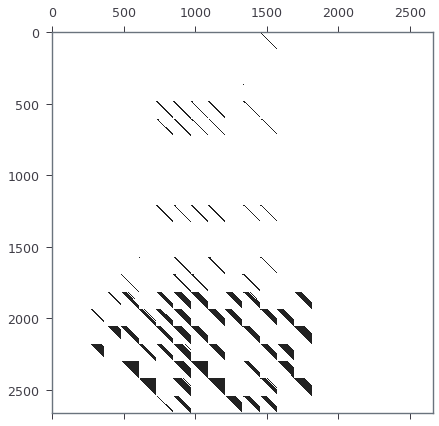

In [185]:

x=b[0]
plt.spy(b)

<ipython-input-198-a78fa94cced3>:1: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(mceq_run.e_grid,5.29e-4/mceq_run.pman[211].inverse_decay_length(),label='pi+')


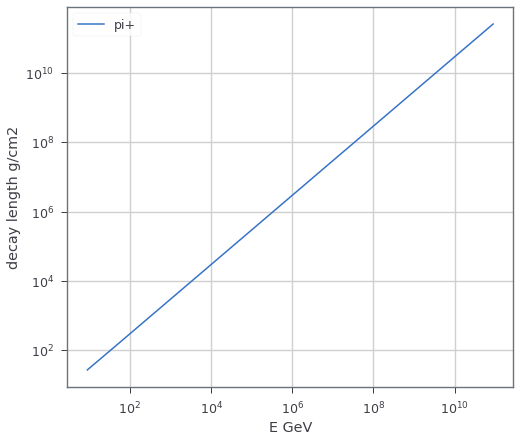

In [198]:
plt.loglog(mceq_run.e_grid,5.29e-4/mceq_run.pman[211].inverse_decay_length(),label='pi+')
plt.grid()
plt.xlabel('E GeV')
plt.ylabel('decay length g/cm2')
plt.legend()


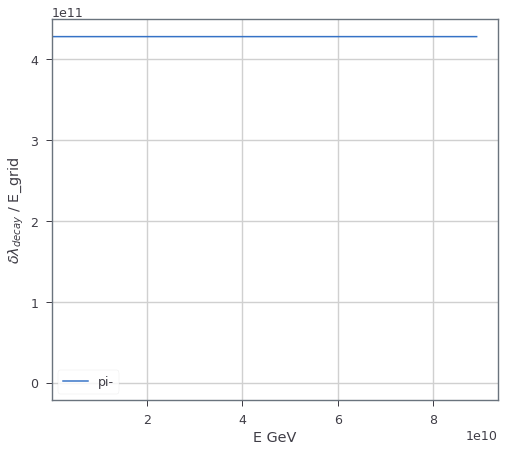

In [93]:


plt.plot(mceq_run.e_grid, deviation,label='pi-')
            #for j in len(self.particles):
plt.ylabel(r"$\delta\lambda_{decay}$ / E_grid")
plt.xlabel("E GeV")
plt.xlim(1e3)
#plt.ylim(-1000,)
plt.grid()
plt.legend()
d_part={}

In [182]:
deviation#this is how the offset for all the particles , offset itself would be different of course a const

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.])

In [69]:
pi=4.277e+11, k=2.07e11, mu =1.8907e11

(4.3188548864758145, 2.734375)

In [16]:
decay_dists


        n0:
        is_hadron     : True
        is_lepton     : False
        is_nucleus    : False
        is_stable     : False
        is_mixed      : True
        is_resonance  : False
        is_tracking   : False
        is_projectile : True
        mceqidx       : 21
        E_mix         : 5.6e-01 GeV